## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
data_path = 'data/ab_data.csv'
country_path = 'data/countries.csv'

df = pd.read_csv(data_path)
#country = pd.read_csv(country_path)

b. Use the below cell to find the number of rows in the dataset.

In [3]:
rows = df.shape[0]
print(f'The number of rows is {rows:,}')

The number of rows is 294,478


c. The number of unique users in the dataset.

In [4]:
unique = df.user_id.nunique()
print(f'The number of unique users is {unique:,}')

The number of unique users is 290,584


d. The proportion of users converted.

In [5]:
converted = df.converted.value_counts(normalize=True).loc[1]
print(f'The proportion of users converted is {converted:.2%}')

The proportion of users converted is 11.97%


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
no_match = df.query('~((landing_page == "new_page") == (group == "treatment"))').shape[0]
print(f"The number of times the new_page and treatment don't line up is {no_match:,}")

The number of times the new_page and treatment don't line up is 3,893


f. Do any of the rows have missing values?

In [7]:
missing = df.isna().any(axis=1).sum()

if missing == 0:
    print(f'There are no missing values')
else:
    print(f'The number of rows with missing values is {missing}')

There are no missing values


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query('((landing_page == "new_page") == (group == "treatment"))')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
unique = df2.user_id.nunique()
print(f'The number of unique users is {unique:,}')

The number of unique users is 290,584


b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
user = df2[df2.user_id.duplicated()].user_id.iloc[0]
print(f'The repeated user ID is {user}')

The repeated user ID is 773192


c. What is the row information for the repeat **user_id**? 

In [12]:
info = df2[df2.user_id.duplicated()]
user_id = info.user_id.iloc[0]
landing_page = info.landing_page.iloc[0]
group = info.group.iloc[0]
converted = info.converted.iloc[0]

print(f'The repeated user info is:\n'
      f'User-ID: {user_id}\n'
      f'Landing Page: {landing_page}\n'
      f'Test Group: {group}\n'
      f'Converted: {converted}')

The repeated user info is:
User-ID: 773192
Landing Page: new_page
Test Group: treatment
Converted: 0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2[~df2.user_id.duplicated()]

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
p_converted = df2.converted.value_counts(normalize=True).loc[1]
print(f'The probability of converting {p_converted:.4f}')

The probability of converting 0.1196


b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control = df2.query('group == "control"').converted.value_counts(normalize=True).loc[1]
print(f'The probability of converting {p_control:.4f}')

The probability of converting 0.1204


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment = df2.query('group == "treatment"').converted.value_counts(normalize=True).loc[1]
print(f'The probability of converting {p_treatment:.4f}')

The probability of converting 0.1188


d. What is the probability that an individual received the new page?

In [17]:
p_newpage = df2.landing_page.value_counts(normalize=True).loc['new_page']
print(f'The probability of recieving the new page {p_newpage:.4f}')

The probability of recieving the new page 0.5001


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Answer**
- Starting from the result of question (d), since the probability of getting either pages is the same, then we can reach a good decision by looking at the probability of conversion of each group.  
  
- It can be seen that the probability of conversion in the control group (the ones using the old page) is higher than the probability of conversion in the treatment group (the ones using the new page) although not by a great margin but this goes in favor of the new page being not so effective in increasing the conversion rates for the company.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer**  
  
**Null Hypothesis:**   $P_{old}$ $\geqslant$ $P_{new}$  
**Alternative Hypothesis:**   $P_{old}$ $\lt$ $P_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [18]:
p_old = p_new = p_converted

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
print(f'The convert rate of P_new is {p_new:.4f}')

The convert rate of P_new is 0.1196


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
print(f'The convert rate of P_new is {p_old:.4f}')

The convert rate of P_new is 0.1196


c. What is $n_{new}$?

In [21]:
n_new = df2.landing_page.value_counts().loc['new_page']
print(f'n_new is {n_new:,}')

n_new is 145,310


d. What is $n_{old}$?

In [22]:
n_old = df2.landing_page.value_counts().loc['old_page']
print(f'n_old is {n_old:,}')

n_old is 145,274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(1,p_new,n_new)
p_new_boot = new_page_converted.mean()

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1,p_old,n_old)
p_old_boot = old_page_converted.mean()

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
p_new_boot-p_old_boot

0.0018355538353995449

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
for i in range(0,10000):
    new_page_converted = np.random.binomial(1,p_new,n_new)
    p_new_boot = new_page_converted.mean()
    old_page_converted = np.random.binomial(1,p_old,n_old)
    p_old_boot = old_page_converted.mean()
    p_diff = p_new_boot - p_old_boot
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

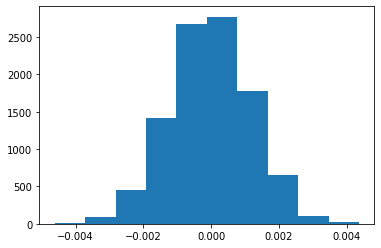

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
p_diff_sample = p_treatment - p_control

(p_diffs > p_diff_sample).mean()

0.9025

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value calculated in the previous question is the p-value, this value denotes the probability that our statistic follows the null hypothesis, and a value of about 90%  indicates a very high probability of following the null hypothesis meaning that the null hypothesis is True.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.value_counts(normalize=False).loc[1]
convert_new = df2.query('group == "treatment"').converted.value_counts(normalize=False).loc[1]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new], alternative = 'smaller', prop_var=False)

print(f'The z-score is {z_score}\nThe p-value is {p_value}')

The z-score is 1.3109241984234394
The p-value is 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score represents the location of the calculated statistic in a standard normal distribution to be compared with the standard normal distribution table. The p-value computed (about 90%) is very high indicating that we cannot reject the null hypothesis meaning that the conversion rate of the new page is not higher than the conversion rate of the old page**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression as it is used to estimate models for binary dependant variables**  
converted = intercept + group

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
#create an intercept column filled with zeros
df2['intercept'] = 1
#create the ab_page column with 1 representing treatment group and 0 for control group
df2['ab_page'] = 1
df2.loc[df2['group'] == 'control', 'ab_page'] = 0

In [32]:
#check if transformed correctly
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
logit_model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

In [34]:
logit_model_result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
logit_model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Mar 2021   Pseudo R-squ.:               8.077e-06
Time:                        20:25:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**If we set the significance level to** $\alpha = 0.05$

**The p-value of the ab_page in the regression model is 0.19 which is > 0.05 and leads us to fail to reject the null hypothesis which states that the variable (ab_page) has no statistically significant effect on conversion meaning that the new page has no significant effect**

$$Null\ Hypothesis:   \beta_{ab\_page} = 0$$
$$Alternative\ Hypothesis:   \beta_{ab\_page} \neq 0$$

**This differs from the hypothesis test in part II as that test was about comparing the proportions of the sample between the users who received the new page and the users who received the old page**

$$Null\ Hypothesis:   P_{old} \geqslant P_{new}$$
$$Alternative\ Hypothesis:   P_{old} \lt P_{new}$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
countries_df = pd.read_csv('./data/countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [37]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [38]:
#check the countries
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
### Create the necessary dummy variables using pandas built-in get dummies
df_new[sorted(list(df_new.country.unique()))] = pd.get_dummies(df_new['country']).sort_index(1)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [40]:
#use only two of the three dummy variables to avoid the dummy variable trap
logit_model = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US','UK']])
logit_model_result = logit_model.fit()
logit_model_result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 16 Mar 2021   Pseudo R-squ.:               2.323e-05
Time:                        20:25:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

**Looking at the p-values of the newly added country dummy varibales, they both have a p-value > 0.05 and that leads us to fail to reject the null hypothesis which means that both variables have no statistically significant effect on conversion meaning that being in a different country has no effect on conversion**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
#create additional columns
df_new['page*US'] = df_new['ab_page']*df_new['US']
df_new['page*UK'] = df_new['ab_page']*df_new['UK']
df_new['page*CA'] = df_new['ab_page']*df_new['CA']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,page*US,page*UK,page*CA
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [42]:
### Fit Your Linear Model And Obtain the Results
logit_model = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US','page*US','UK','page*UK']])
logit_model_result = logit_model.fit()
logit_model_result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 16 Mar 2021   Pseudo R-squ.:               3.482e-05
Time:                        20:25:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
page*US        0.0469      0.054      0.872      0.383      -0.059       0.152
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
page*UK        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

**We notice that the additional columns for the interaction between the presented page and country of the user both have p-value > 0.05 which means that we fail to reject the null hypothesis indicating that both variables have no statistically significant effect on conversion adding further proof that being presented the new page and being in a specific country does not affect the conversion.**

<a id='conclusions'></a>
## Conclusions

To conclude our analysis,
<li>it is hsown that the new landing page has no significant effect on the conversion.  
<li>We followed multiple analysis methods (testing the difference of proportions, hypothesis testing using the z-scores and regression models). 
<li>We also tested the statistical significance of multiple variables on the conversion rate using regression, we tested the effect of arriving at the new landing page and whether the conversion is affected by being in different countries (Canada, United Kingdom, United States).  
<li>The sample size is fairly large (about 290 thousand) which makes us believe that the new page is not effective and we should design a new page and conduct another test.